In [1]:
import pickle
from tqdm import tqdm
from scpredict.settings import *
import pandas as pd
from scpredict.parsing import ZBulkParser

parser = ZBulkParser()
parsed_replays = parser.parse_folder('replays_raw')
with open('replays_processed/zephyrus/parsed.pt', 'wb') as f:
    pickle.dump(parsed_replays, f)

368it [08:19,  1.69s/it]

Error processing replays_raw\20230506 - Game 1 - trigger vs Cham - PvZ - Royal Blood.SC2Replay: 'int' object has no attribute 'game_id'


1010it [23:47,  1.33s/it]

Error processing replays_raw\20231027 - Game 1 - BattleB vs Krystianer - TvP - Oceanborn.SC2Replay: b'Terranie'


1042it [24:22,  1.20it/s]

Error processing replays_raw\20231027 - Game 2 - BattleB vs Krystianer - TvP - Hard Lead.SC2Replay: b'Terranie'


1071it [24:53,  1.27s/it]

Error processing replays_raw\20231027 - Game 3 - BattleB vs Krystianer - TvP - Solaris.SC2Replay: b'Terranie'


2668it [1:04:33,  1.32s/it]

Error processing replays_raw\Ro8 SpeCial vs [MYG1]Bunny [ZvT] - G1 [ESL] Hecate.SC2Replay: None


4090it [1:33:42,  1.11s/it]

Error processing replays_raw\[sc2rep.ru_1600190606]_1x1_rumspaceham(Z)_SICAY(P).SC2Replay: b'\xd0\x97\xd0\xb5\xd1\x80\xd0\xb3\xd0\xb8'


4443it [1:44:35,  1.41s/it]


In [9]:
import pickle
from tqdm import tqdm
from scpredict.settings import *
import pandas as pd

path_to_parsed_replays = 'replays_processed/zephyrus/parsed.pt'
with open(path_to_parsed_replays, 'rb') as f:
    parsed_replays = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'replays_processed/zephyrus/parsed.pt'

In [5]:
import warnings

for matchup in matchups:

    print(f'Aggregating matchup data for {matchup}')

    unique_features = set()
    for entry in tqdm(parsed_replays[matchup]):
        unique_features.update(entry.keys())
    # Convert the set to a list
    unique_features = list(unique_features)

    # List to collect rows
    rows = []

    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)

        for entry in tqdm(parsed_replays[matchup]):
            # Create a dictionary with all features, setting missing ones to None
            row = {feature: entry.get(feature, None) for feature in unique_features}
            # Append the row to the list
            rows.append(row)

    # Convert the list of rows to a DataFrame
    df = pd.DataFrame(rows, columns=unique_features)

    df.to_csv(f'replays_processed/zephyrus/{matchup}.csv', index=False)

Aggregating matchup data for pvp


100%|██████████| 73265/73265 [00:01<00:00, 39305.96it/s]


Aggregating matchup data for pvt


100%|██████████| 95063/95063 [00:02<00:00, 35698.50it/s]


Aggregating matchup data for pvz


100%|██████████| 331835/331835 [00:11<00:00, 30063.51it/s]


Aggregating matchup data for tvz


100%|██████████| 81888/81888 [00:02<00:00, 27599.63it/s]


Aggregating matchup data for tvt


100%|██████████| 39709/39709 [00:01<00:00, 28776.07it/s]


Aggregating matchup data for zvz


100%|██████████| 23271/23271 [00:00<00:00, 31922.56it/s]


In [36]:
import shap
from scpredict.settings import *
train = {}
explainers = {}
for matchup in matchups:
    data_path = f'replays_processed/zephyrus/{matchup}.csv'
    matchup_data = pd.read_csv(data_path).fillna(0).drop(['winner'], axis=1)
    train[matchup] = matchup_data
    model_path = f'saved_models/logit/{matchup}.pkl'
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    explainer = shap.LinearExplainer(model, matchup_data)
    explainers[matchup] = explainer
    shap_path = f'saved_models/shap/{matchup}_shap.pkl'
    with open(shap_path, 'wb') as f:
        pickle.dump(explainer, f)


In [37]:
from scpredict.scpredict import Predictor

In [38]:
parser = Predictor()
replay, importance = parser.get_shap('tes.SC2Replay')

In [39]:
importance.head(20)

,Feature,Mean Absolute SHAP Value
246,player1_Disruptor_dead,185.653793
184,player1_RoboticsFacility_dead,174.151657
162,player1_Sentry_dead,117.122535
57,player2_OrbitalCommand_alive,114.952123
280,player2_SiegeTank_dead,106.863572
99,player1_Stalker_prod,52.199500
182,player2_LiberatorAGRangeUpgrade,38.691708
238,player1_WarpPrism_dead,35.037697
18,player1_ProtossGroundArmorsLevel1,23.601974
179,player2_BarracksReactor_prod,10.935436


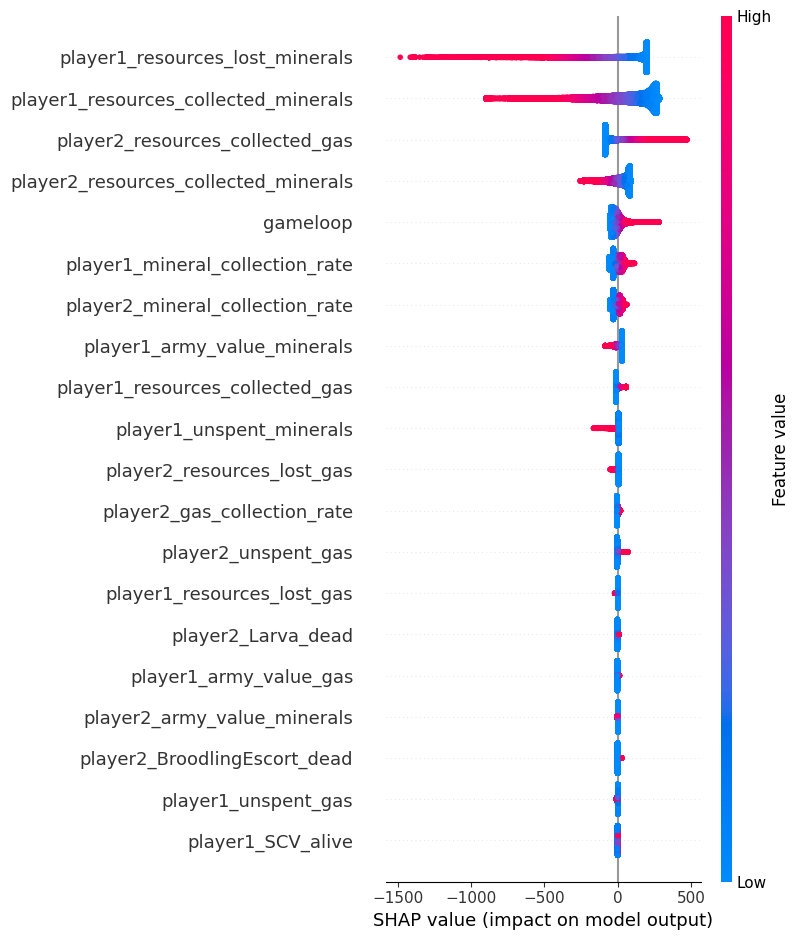

In [50]:
import shap
shap.summary_plot(explainers['tvz'](train['tvz']), train['tvz'], feature_names=list(train['tvz'].columns))

In [55]:
sample_size = 1000  # Adjust the sample size based on available memory and dataset size
X_sample = train['pvz'].sample(n=sample_size, random_state=42)

shap.force_plot(explainers['pvz'].expected_value, explainers['pvz'].shap_values((train['pvz'])), train['pvz'], feature_names=train['pvz'].columns)

c:\Users\HammerHao\Documents\GitHub\scPredict\.venv\Lib\site-packages\shap\plots\_force.py:208: UserWarning: shap.plots.force is slow for many thousands of rows, try subsampling your data.
  warnings.warn("shap.plots.force is slow for many thousands of rows, try subsampling your data.")


MemoryError: Unable to allocate 410. GiB for an array with shape (55057067695,) and data type float64

In [51]:
explainers['pvz'].expected_value

237.34039619426665

In [34]:
explainers['pvt'].

197.4233205390311